### 0.import library and set configration

In [1]:
import os
import pandas as pd
import numpy as np
import scipy as sp
from scipy.stats import norm
# „Ç∞„É©„Éï„Çí„Ç§„É≥„É©„Ç§„É≥„ÅßË°®Á§∫„Åï„Åõ„Çã
import matplotlib.pyplot as plt
import japanize_matplotlib #Êó•Êú¨Ë™ûÂåñmatplotlib
%matplotlib inline

import seaborn as sns
sns.set(font="IPAexGothic") #Êó•Êú¨Ë™û„Éï„Ç©„É≥„ÉàË®≠ÂÆö

from ydata_profiling import ProfileReport

import warnings
# ÂÖ®„Å¶„ÅÆË≠¶Âëä„ÇíÁÑ°Ë¶ñ„Åô„Çã
warnings.filterwarnings("ignore")

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Ê©üÊ¢∞Â≠¶ÁøíÁî®„ÅÆ„É©„Ç§„Éñ„É©„É™„Ç§„É≥„Çπ„Éà„Éº„É´
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import optuna
import shap


In [3]:
import geopandas as gpd


In [4]:
#import_original_function
from function.data_processing import test2
from function.data_processing import addtional_process
from function.modeling import objective

In [5]:
#pandas„ÅÆË°®Á§∫Ë®≠ÂÆö
# Ë°®Á§∫Âà∂Èôê„ÅÆÁ∑©Âíå
pd.set_option('display.max_columns', 300 )
pd.set_option('display.max_rows', 500 )
# ÊåáÊï∞Ë°®Ë®ò„ÅÆÁÑ°ÂäπÂåñ
pd.options.display.float_format = '{:.2f}'.format

In [6]:
#config„Éï„Ç°„Ç§„É´„ÅÆË™≠„ÅøËæº„Åø
import configparser
config_ini = configparser.ConfigParser()
config_ini.read('./config/config.ini', encoding='utf-8')

['./config/config.ini']

In [7]:
#read_file_congfig
test_file = config_ini["INPUT_FILE"]["test"]
train_file = config_ini["INPUT_FILE"]["train"]
deginition_file = config_ini["CONFIG_FILE"]["deginition"]
submit_file = config_ini["OUTPUT_FILE"]["submit"]
shap_plot_file = config_ini["OUTPUT_FILE"]["shap_plot"]
#read_var_config
response_var = config_ini["VAR"]["response_var"]
#read_other_info
version = config_ini["VERSION"]["version"]


In [28]:
#make_output_folder
ouput_folder_path  = f"./output/ver{version}/"
os.makedirs(ouput_folder_path, exist_ok=True) 

### 1.import_train/test_data


In [9]:
#„Éá„Éº„Çø„ÅÆÊàêÂûãÊñπÊ≥ï„ÇíË™≠Ëæº
df_deginition  = pd.read_excel(deginition_file,index_col=0, dtype = 'object')
df_deginition  = df_deginition.query('Êé°Âê¶ == "‚óé"|Êé°Âê¶ == "„Äá"| Êé°Âê¶ == "‚ñ≥"')

#Â≠¶Áøí„Å´‰Ωø„ÅÜ„Ç´„É©„É†„ÇíÈÅ∏Êäû
target_columns = df_deginition["Êú¨Áï™„Éá„Éº„ÇøÁâπÂæ¥ÈáèÂêç"].values.tolist()

# #„ÉÄ„Éü„ÉºÂ§âÊï∞Âåñ„Åô„Çã„Ç´„É©„É†„ÇíÈÅ∏Êäû
# dummy_columns = df_deginition.query("„ÉÄ„Éü„ÉºÂ§âÊï∞Âåñ == '„Äá'")["Êú¨Áï™„Éá„Éº„ÇøÁâπÂæ¥ÈáèÂêç"].values.tolist()


In [10]:
# ÂØæË±°„ÅÆCSV„Éá„Éº„Çø„ÅÆË™≠Ëæº
df_train_raw = pd.read_csv(train_file , header=0,sep=',' , dtype = 'object')
df_test_raw  = pd.read_csv(test_file  , header=0,sep=',' , dtype = 'object')

In [11]:
# shp_path = "./input/ÂõΩÂúüÊï∞ÂÄ§ÊÉÖÂ†±„Éá„Éº„Çø/‰∫∫Âè£Êé®Áßª/500m_mesh_2018_14.shp"
# gdf_population = gpd.read_file(shp_path, encoding='cp932')  # ShapefileË™≠Ëæº

### 2.data_processing

#### 2-1.select_varriables

In [12]:
# ÂØæË±°„Ç´„É©„É†„ÇíÁµû„ÇäËæº„Åø
df_train = df_train_raw[target_columns]
df_test = df_test_raw[[col for col in target_columns if not col == response_var]]

# ÊäΩÂá∫ÁµêÊûú„ÇíË°®Á§∫
display(df_train.head(2))
display(df_test.head(2))

money_room building_status building_type unit_count building_structure  \
0      38000               1             3         22                  1   
1     103000               1             1        NaN                  4   

  floor_count year_built room_floor dwelling_unit_window_angle room_count  \
0           2     200210          2                          5          1   
1           3     197612          1                          5          2   

    unit_area bukken_type post1 post2 addr1_1 addr1_2 walk_distance1  \
0  23.1800003        3102   598    44      27     213           1040   
1  47.7000008        3101   173    36      13     119            320   

  walk_distance2 flg_new room_kaisuu snapshot_window_angle madori_number_all  \
0            NaN       0           2                     5                 1   
1            400       0           1                     5                 2   

  madori_kind_all parking_kubun genkyo_code convenience_distance  \
0              20             1           3                  239   
1              30             3           2                  399   

  super_distance  
0           1280  
1            434

building_status building_type unit_count building_structure floor_count  \
0               1             3          6                 10           2   
1               1             1         15                  4           3   

  year_built room_floor dwelling_unit_window_angle room_count   unit_area  \
0     201101          2                          6          2  62.5099983   
1     198703          3                          5          1  19.4400005   

  bukken_type post1 post2 addr1_1 addr1_2 walk_distance1 walk_distance2  \
0        3102   756    57      35     216            160            NaN   
1        3101   182     7      13     208            240            800   

  flg_new room_kaisuu snapshot_window_angle madori_number_all madori_kind_all  \
0       0           2                     5                 2              50   
1       0           3                     5                 1              20   

  parking_kubun genkyo_code convenience_distance super_distance  
0             1           2                  NaN            NaN  
1             4           3                  190             30

#### 2-2.replace data_type and NA

In [13]:
#ÂâçÂá¶ÁêÜÔºà„Éá„Éº„ÇøÂûãÂ§âÊèõ„ÄÅË£úÂÆåÔºâ

# Ê¨†ÊêçÂÄãÊâÄ„ÇíNA„Å®„ÅÑ„ÅÜÊñáÂ≠óÂàó„ÅßÁΩÆÊèõ
df_train = df_train.fillna("NA")
df_test = df_test.fillna("NA")

for idx ,raw  in df_deginition.iterrows():
    #„Éá„Éº„Çø„ÅÆÂ§âÊèõÂØæË±°„ÄÅÂ§âÊèõÊñπÊ≥ï„ÇíÁ¢∫Ë™ç
    col = raw["Êú¨Áï™„Éá„Éº„ÇøÁâπÂæ¥ÈáèÂêç"]
    complement_value = raw["Ê¨†ÊêçË£úÂÆåÊñπÊ≥ï"]
    type = raw["„Éá„Éº„ÇøÂûã"]

    #Ë£úÂÆåÂÄ§„ÅåÁ©∫„Åß„Å™„Åë„Çå„Å∞Ë£úÂÆå
    if complement_value != np.nan : 
        try:
            df_train[col] = df_train[col].replace("NA",complement_value)
        except Exception as e:
            print("Ë£úÂÆå",col,complement_value,type)
            print(f"„Ç®„É©„Éº„ÅåÁô∫Áîü„Åó„Åæ„Åó„Åü: {e}")
        try:
            df_test[col] = df_test[col].replace("NA",complement_value)
        except Exception as e:
            print("Ë£úÂÆå",col,complement_value,type)
            print(f"„Ç®„É©„Éº„ÅåÁô∫Áîü„Åó„Åæ„Åó„Åü: {e}")

    #„Éá„Éº„ÇøÂûãÂ§âÊèõ
    try:
        df_train[col] = df_train[col].astype(type)
    except Exception as e:
        print("ÁΩÆÊèõ",col,complement_value,type)
        print(f"„Ç®„É©„Éº„ÅåÁô∫Áîü„Åó„Åæ„Åó„Åü: {e}")
    try:
        df_test[col]  = df_test[col].astype(type)
    except Exception as e:
        print("ÁΩÆÊèõ",col,complement_value,type)
        print(f"„Ç®„É©„Éº„ÅåÁô∫Áîü„Åó„Åæ„Åó„Åü: {e}")



Ë£úÂÆå money_room 0 int
„Ç®„É©„Éº„ÅåÁô∫Áîü„Åó„Åæ„Åó„Åü: 'money_room'
ÁΩÆÊèõ money_room 0 int
„Ç®„É©„Éº„ÅåÁô∫Áîü„Åó„Åæ„Åó„Åü: 'money_room'


#### 2-3.additional_processing

In [14]:
#ÁâπÊÆäÂâçÂá¶ÁêÜ
df_train = addtional_process(df_train)
df_test  = addtional_process(df_test)

In [15]:
#train_data„ÅÆ„ÅøËøΩÂä†Âá¶ÁêÜ

# Êù±‰∫¨ÈÉΩÔºàaddr1_1=13Ôºâ‰ª•Â§ñ„ÅÆ100‰∏áÂÜÜ‰ª•‰∏ä„ÅÆ„Éá„Éº„Çø„Çí‰∏≠Â§ÆÂÄ§„ÅÆ52000ÂÜÜ„ÅßÁΩÆÊèõ
df_train.loc[(df_train['addr1_1'] != '13') & (df_train['money_room'] >= 1000000), 'money_room'] = df_train['money_room'].median()

df_train["unit_area"] = df_train["unit_area"].fillna(0)
df_train["unit_area"] = df_train["unit_area"].astype(type)

# # df_train['unit_area']„Åå300‰ª•‰∏ä„ÄÅdf_train['money_room']„Åå50‰∏áÂÜÜ‰ª•‰∏ã„ÅÆÁâ©‰ª∂„Çí‰∏≠Â§ÆÂÄ§„ÅßÁΩÆÊèõ
df_train.loc[(df_train['unit_area'] >= 300) & (df_train['money_room'] < 500000), 'unit_area'] = df_train['unit_area'].median()

# year_built„Åå70‰ª•‰∏ä„ÅÆÁâ©‰ª∂„Çí„ÄÅyear_built„ÅÆ‰∏≠Â§ÆÂÄ§„ÅßÁΩÆÊèõ
df_train.loc[df_train['year_built'] > 70, 'year_built'] = df_train['year_built'].median()

# floor_count„Åå70‰ª•‰∏ä„ÅÆÁâ©‰ª∂„Çí„ÄÅfloor_count„ÅÆ‰∏≠Â§ÆÂÄ§„ÅßÁΩÆÊèõ
df_train.loc[df_train['floor_count'] > 64, 'floor_count'] = df_train['floor_count'].median()


In [16]:
#„Éá„Éº„Çø„ÅÆÊ∞¥Â¢ó„Åó
price_th = 500000
low_price_data = df_train.query(f"money_room <{price_th}")
high_price_data = df_train.query(f"money_room >={price_th}")
data_count_rate = len(low_price_data)/len(high_price_data) #‰Ωé‰æ°Ê†º„Éá„Éº„Çø„ÅåÈ´ò‰æ°Ê†º„Éá„Éº„Çø„ÅÆ‰ΩïÂÄçÂ≠òÂú®„Åó„Å¶„ÅÑ„Çã„Åã„ÅÆÊØîÁéá
data_count_rate = int(data_count_rate)
print("‰Ωé‰æ°Ê†ºÁâ©‰ª∂Êï∞Ôºö",len(low_price_data))
print("È´ò‰æ°Ê†ºÁâ©‰ª∂Êï∞Ôºö",len(high_price_data))
print("ÊØîÁéáÔºö",data_count_rate)

‰Ωé‰æ°Ê†ºÁâ©‰ª∂Êï∞Ôºö 584272
È´ò‰æ°Ê†ºÁâ©‰ª∂Êï∞Ôºö 235
ÊØîÁéáÔºö 2486


In [17]:
expanded_low_price_data = pd.concat([high_price_data] * data_count_rate, ignore_index=True)
expanded_low_price_data

money_room  building_status  building_type  unit_count  \
0          1350000                1              1         195   
1          1100000                1              1         147   
2          1000000                1              1         147   
3           580000                1              1          18   
4           500000                1              1           6   
...            ...              ...            ...         ...   
584205      780000                1              1          92   
584206      594000                1              1          92   
584207     1200000                1              1           1   
584208      550000                1              1          33   
584209      760000                1              1          17   

        building_structure  floor_count  year_built  room_floor  \
0                        5           32          23          15   
1                        5           19          54          11   
2                        5           19          54          10   
3                        4            5           8           3   
4                        4            3          37           3   
...                    ...          ...         ...         ...   
584205                   5            8          25           5   
584206                   5            8          25           2   
584207                   4            5           8           2   
584208                   4           12           8          12   
584209                   4            8          24           3   

        dwelling_unit_window_angle  room_count  unit_area  bukken_type  post1  \
0                                5           3     186.49         3101    106   
1                                0           1       0.00         3101    108   
2                                2           4     246.36         3101    108   
3                                3           3      77.87         3101    108   
4                                5           3     162.86         3101    602   
...                            ...         ...        ...          ...    ...   
584205                           8           3     119.79         3101    106   
584206                           4           2      89.16         3101    106   
584207                           6           2     154.49         3101    106   
584208                           5           3      90.24         3101    108   
584209                           4           3     149.81         3101    107   

        post2 addr1_1  addr1_2  walk_distance1  walk_distance2  flg_new  \
0          32      13      103              80             480        0   
1          73      13      103             560             800        0   
2          73      13      103             720             800        0   
3          73      13      103             480             880        0   
4        8003      26      102             720            1920        0   
...       ...     ...      ...             ...             ...      ...   
584205     31      13      103             640             960        0   
584206     31      13      103             640            1040        0   
584207     32      13      103             320             320        0   
584208     71      13      103              80              80        0   
584209     52      13      103             320             320        0   

        room_kaisuu  snapshot_window_angle  madori_number_all  \
0                15                      5                  3   
1                11                      7                  4   
2                10                      2                  4   
3                 3                      3                  3   
4                 3                      5                  3   
...             ...                    ...                ...   
584205            5                      8                  3   
584206          

In [18]:
df_train  = pd.concat([df_train,expanded_low_price_data],ignore_index=True)
df_train

money_room  building_status  building_type  unit_count  \
0             38000                1              3          22   
1            103000                1              1           1   
2             50000                1              3           1   
3             37000                1              3           1   
4             33000                1              3           1   
...             ...              ...            ...         ...   
1168712      780000                1              1          92   
1168713      594000                1              1          92   
1168714     1200000                1              1           1   
1168715      550000                1              1          33   
1168716      760000                1              1          17   

         building_structure  floor_count  year_built  room_floor  \
0                         1            2          23           2   
1                         4            3          49           1   
2                         1            3          29           2   
3                         3            2          32           1   
4                         3            2          32           2   
...                     ...          ...         ...         ...   
1168712                   5            8          25           5   
1168713                   5            8          25           2   
1168714                   4            5           8           2   
1168715                   4           12           8          12   
1168716                   4            8          24           3   

         dwelling_unit_window_angle  room_count  unit_area  bukken_type  \
0                                 5           1      23.18         3102   
1                                 5           2      47.70         3101   
2                                 3           2      46.35         3102   
3                                 6           2      39.74         3102   
4                                 6           2      39.74         3102   
...                             ...         ...        ...          ...   
1168712                           8           3     119.79         3101   
1168713                           4           2      89.16         3101   
1168714                           6           2     154.49         3101   
1168715                           5           3      90.24         3101   
1168716                           4           3     149.81         3101   

         post1  post2 addr1_1  addr1_2  walk_distance1  walk_distance2  \
0          598     44      27      213            1040            9999   
1          173     36      13      119             320             400   
2           65     21      01      103             880            1120   
3          720     92      34      207             700             700   
4          720     92      34      207            2012            3532   
...        ...    ...     ...      ...             ...             ...   
1168712    106     31      13      103             640             960   
1168713    106     31      13      103             640            1040   
1168714    106     32      13      103             320             320   
1168715    108     71      13      103              80              80   
1168716    107     52      13      103             320             320   

         flg_new  room_kaisuu  snapshot_window_angle  madori_number_all  \
0              0            2                      5                  1   
1              0            1                      5                  2   
2              0            2                      3                  2   
3              0            1                      6                  2   
4              0            2                      7                  2   
...          ...          ...                    ...                ...   
1168712        0            5                      8                  3 

#### 2-4.validation

In [19]:
# ‰∫àÊ∏¨ÂØæË±°„ÅÆ„Éá„Éº„Çø„ÇíÂ≠¶ÁøíÁî®„Å®Ë©ï‰æ°Áî®„Å´ÂàÜÂâ≤Ôºà„Éê„É™„Éá„Éº„Ç∑„Éß„É≥Ôºâ
df_x = df_train.loc[:, df_train.columns!= response_var]
# df_x = pd.get_dummies(data = df_x,columns=dummy_columns, dtype='int')
df_x = pd.get_dummies(data = df_x, dtype='int')

df_y = df_train[response_var]

# Â≠¶ÁøíÁî®ÔºöË©ï‰æ°Áî®„Åå70%Ôºö30%
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=0)

### 3.modeling

In [20]:
# Optuna„Å´„Çà„Çã„Éè„Ç§„Éë„Éº„Éë„É©„É°„Éº„Çø„ÅÆÊúÄÈÅ©Âåñ
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, df_x_train, df_y_train, df_x_test, df_y_test), 
               n_trials=100)
print(f"ÊúÄÈÅ©„Å™„Éë„É©„É°„Éº„Çø: {study.best_params}")

# ÊúÄÈÅ©„Å™„Éë„É©„É°„Éº„Çø„Çí‰ΩøÁî®„Åó„Å¶ÊúÄÁµÇ„É¢„Éá„É´„ÅÆ„Éà„É¨„Éº„Éã„É≥„Ç∞
best_params = study.best_params
best_params['objective'] = 'regression'
best_params['metric'] = 'rmse'

model = lgb.train(best_params, 
                    lgb.Dataset(df_x_train, label=df_y_train), 
                    valid_sets=[lgb.Dataset(df_x_test, label=df_y_test)])


ÊúÄÈÅ©„Å™„Éë„É©„É°„Éº„Çø: {'learning_rate': 0.08573961717517849, 'num_leaves': 100, 'min_data_in_leaf': 10, 'feature_fraction': 0.6642461241239085, 'bagging_fraction': 0.8904440323414212, 'bagging_freq': 1}


In [29]:
#model„ÅÆÂá∫Âäõ
import pickle
pickle.dump(model, open(ouput_folder_path+'model.pkl', 'wb'))


### 4.evaluation

In [33]:
#„É¢„Éá„É´„ÅÆË™≠„ÅøËæº„Åø
model = pickle.load(open(ouput_folder_path+'model.pkl', 'rb'))

In [34]:
#„ÉÜ„Çπ„Éà„Éá„Éº„Çø„ÅÆ‰∫àÊ∏¨ÁµêÊûú
y_pred = model.predict(df_x_test, num_iteration=model.best_iteration)
rmse = mean_squared_error(df_y_test, y_pred, squared=False)

#„Éà„É¨„Éº„Éã„É≥„Ç∞„Éá„Éº„Çø„ÅÆ‰∫àÊ∏¨ÁµêÊûú
y_pred_train = model.predict(df_x_train, num_iteration=model.best_iteration)
rmse_train = mean_squared_error(df_y_train, y_pred_train, squared=False)

# ‰∫àÂÆü„ÅÆÊØîËºÉ
print(f"RMSEÔºàpredict_trainÔºâ: {rmse}")
print(f"RMSEÔºàtest_trainÔºâ: {rmse_train}")


RMSEÔºàpredict_trainÔºâ: 10026.063819194283
RMSEÔºàtest_trainÔºâ: 9257.102505904546


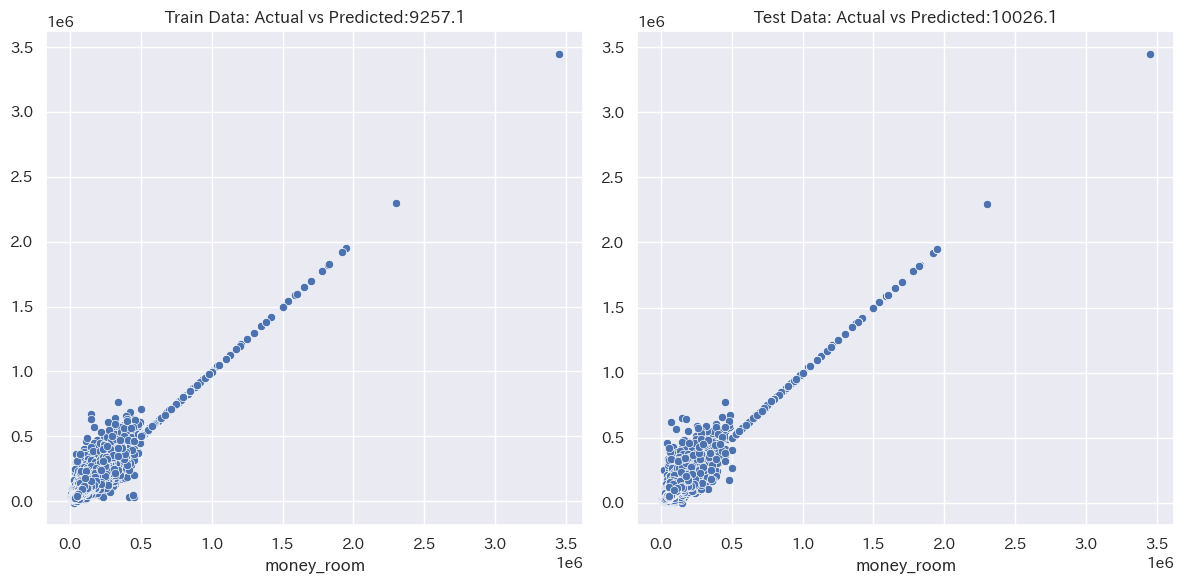

In [32]:
"""
üí°train„Éá„Éº„Çø„ÅÆ‰∫àÊ∏¨Á≤æÂ∫¶„ÅåÁï∞Â∏∏„Å´ËâØ„ÅÑÂ†¥Âêà„ÅØ„Ç™„Éº„Éê„Éº„Éï„Ç£„ÉÉ„ÉÜ„Ç£„É≥„Ç∞„ÅÆÂèØËÉΩÊÄß„Åå„ÅÇ„Çãüí°
"""
# 2„Å§„ÅÆÊï£Â∏ÉÂõ≥„ÇíÊ®™‰∏¶„Å≥„Å´Ë°®Á§∫„Åô„Çã„Åü„ÇÅ„Å´„ÄÅmatplotlib „ÅÆ subplots „Çí‰Ωø„ÅÜ
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1Ë°å2Âàó„ÅÆ„Çµ„Éñ„Éó„É≠„ÉÉ„Éà

# „Çµ„Éñ„Éó„É≠„ÉÉ„Éà1: „Éà„É¨„Éº„Éã„É≥„Ç∞„Éá„Éº„Çø„ÅÆÊï£Â∏ÉÂõ≥
sns.scatterplot(x=df_y_train, y=y_pred_train, ax=axes[0])
axes[0].set_title(f'Train Data: Actual vs Predicted:{round(rmse_train,1)}')  # „Çø„Ç§„Éà„É´„ÇíËøΩÂä†
# „Çµ„Éñ„Éó„É≠„ÉÉ„Éà1: „ÉÜ„Çπ„Éà„Éá„Éº„Çø„ÅÆÊï£Â∏ÉÂõ≥
sns.scatterplot(x=df_y_test, y=y_pred, ax=axes[1])
axes[1].set_title(f'Test Data: Actual vs Predicted:{round(rmse,1)}')  # „Çø„Ç§„Éà„É´„ÇíËøΩÂä†

# „É¨„Ç§„Ç¢„Ç¶„ÉàË™øÊï¥
plt.tight_layout()

# ÁîªÂÉè„Å®„Åó„Å¶‰øùÂ≠ò
plt.savefig(ouput_folder_path+"predict_result.jpg", format="jpg", dpi=300)

# „Éó„É≠„ÉÉ„Éà„ÇíË°®Á§∫
plt.show()


In [24]:
#notebookÂÜÖ„ÅßJavascript„ÇíÂãï„Åã„Åô„Åü„ÇÅ„ÅÆ„Åä„Åæ„Åò„Å™„ÅÑ
shap.initjs()
#TreeExplainer„ÅØ„ÄÅÊ±∫ÂÆöÊú®Á≥ª„ÅÆ„É¢„Éá„É´„ÅÆSHAPÂÄ§„ÇíÂèñÂæó„Åô„Çã„ÇÇ„ÅÆ„ÄÇ
X_test_shap = df_x_test.copy().reset_index(drop=True)
explainer = shap.TreeExplainer(model=model)
shap_values = explainer.shap_values(X=X_test_shap)
#base_shap_value„Å´ÂØæ„Åó„Å¶„ÄÅÂêÑÂ§âÊï∞„ÅÆshap„Çπ„Ç≥„Ç¢√óÂ§âÊï∞„ÅÆÂÄ§„ÇíÊéõ„ÅëÂêà„Çè„Åõ„ÅüÂÄ§„Åå‰∫àÊ∏¨ÂÄ§„Å´„Å™„Çã„ÄÇ
print("base_shap_value",explainer.expected_value)


base_shap_value 436989.6663026888


In [ ]:
ouput_folder_path

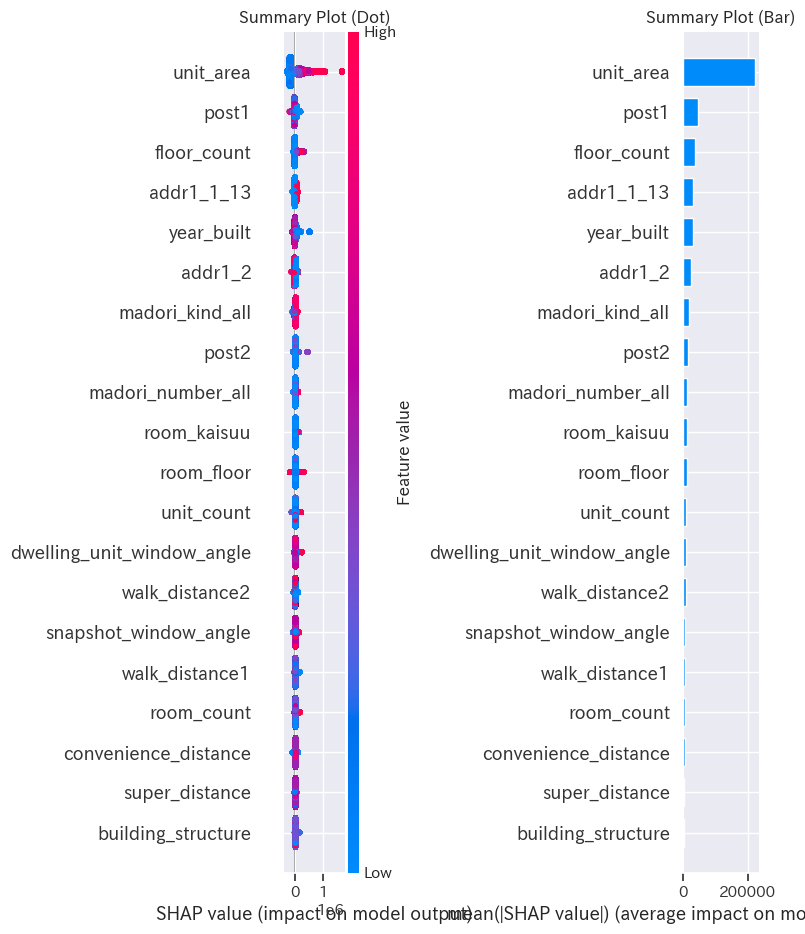

In [25]:
# „Çµ„Éñ„Éó„É≠„ÉÉ„Éà„ÅÆ‰ΩúÊàêÔºàÊ≠£ÊñπÂΩ¢„Å´Ë®≠ÂÆöÔºâ
fig, axes = plt.subplots(1, 2, figsize=(10, 10))  # 1Ë°å2Âàó„ÅÆ„Çµ„Éñ„Éó„É≠„ÉÉ„Éà„ÄÅÊ≠£ÊñπÂΩ¢

# Â∑¶ÂÅ¥„ÅÆÂõ≥: summary_plot
plt.sca(axes[0])  # Â∑¶ÂÅ¥„ÅÆ„Çµ„Éñ„Éó„É≠„ÉÉ„Éà„Çí„Ç¢„ÇØ„ÉÜ„Ç£„Éñ„Å´
shap.summary_plot(shap_values, X_test_shap, plot_type='dot', show=False)
axes[0].set_title("Summary Plot (Dot)", fontsize=12)

# Âè≥ÂÅ¥„ÅÆÂõ≥: bar plot
plt.sca(axes[1])  # Âè≥ÂÅ¥„ÅÆ„Çµ„Éñ„Éó„É≠„ÉÉ„Éà„Çí„Ç¢„ÇØ„ÉÜ„Ç£„Éñ„Å´
shap.summary_plot(shap_values, X_test_shap, plot_type='bar', show=False)
axes[1].set_title("Summary Plot (Bar)", fontsize=12)

# „É¨„Ç§„Ç¢„Ç¶„ÉàË™øÊï¥
plt.tight_layout()

# ÁîªÂÉè„Å®„Åó„Å¶‰øùÂ≠ò
plt.savefig(ouput_folder_path+shap_plot_file, format="jpg", dpi=300)

# „Éó„É≠„ÉÉ„Éà„ÇíË°®Á§∫
plt.show()


#### 5.create submit.csv

In [26]:
#submit

# Ë©ï‰æ°Áî®„Éá„Éº„Çø„ÅßË≥ÉÊñô„Çí‰∫àÊ∏¨
df_test_model_x = df_test
df_test_model_x = pd.get_dummies(df_test_model_x, dtype='int')

y_pred = model.predict(df_test_model_x)

# y_pred„Åã„Çâ„Éá„Éº„Çø„Éï„É¨„Éº„É†„Çí‰ΩúÊàê
pred_df = pd.DataFrame(y_pred, columns=['money_room'])

# pred_df„ÇíCSVÂá∫Âäõ„ÄÅ„Éò„ÉÉ„ÉÄ„Éº„Å™„Åó
pred_df.to_csv(ouput_folder_path + submit_file, index=True, header=False)

# ‰∫àÊ∏¨ÂÄ§„ÇíÁ¢∫Ë™ç
display(pred_df.head())

money_room
0    62879.34
1    51948.36
2    59813.12
3    48446.48
4   107441.93